In [60]:
from brian2 import *
%matplotlib inline
import numpy as np
from numpy import heaviside
from math import *
import pandas as pd
from numba import jit
from matplotlib import cm

@jit
# Potential function
def U(phi,I=1.01,gamma=1,T=4.615120516841259, tau=1):
    value = (I/gamma)*(1-np.exp(-gamma*T*phi/tau))
    return value
@jit
# Function to convert potential to 'phase' corresponding to Mirollo-Strogatz model
def U_inv(y,I=1.01,gamma=1,T=4.615120516841259,tau=1):
    value = (tau/(gamma*T))*np.log((1-(gamma*y/I))**(-1))
    return value
## Loading Inhibitory and Excitatory Edge topology from a 81 × 81 Matrix specifying 20 connections for each neuron 
# Import Sudoku matrices: (rows: pre-synaptic, columns: post-synaptic)

inhib_connect = np.loadtxt('Clueless_Sudoku_inhib.txt', dtype=int)
excit_connect = np.loadtxt('Clueless_Sudoku_excit.txt', dtype=int)

# Get tuples of corresponding connection indices for putting in Brian2's synapse connect() function
inhib_pre, inhib_post = inhib_connect.nonzero()
excit_pre, excit_post = excit_connect.nonzero()

In [61]:
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

csfont = {'fontname':'sans-serif'}
hfont = {'fontname':'serif'}
rcParams.update({'font.family':'serif'})
rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)

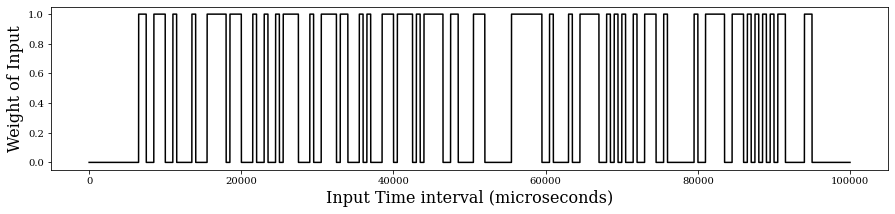

In [62]:
import os
script_dir = os.path.dirname('Intermittent with DC Drive.ipynb')
results_dir = os.path.join(script_dir, 'Only II w1 _Results/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

#Inputs to generate plume
argv=['9','598','22','2']
 
#parameters for resolution and block size
blocktime = 9000 # in ms
sim_res = 0.1 # in ms
min_block = 50 # in ms

#Control over the fine-ness of plume layers
def intermittent(argv): 
  np.random.seed(int(argv[1])+int(argv[2])+int(argv[3]))
  switch_prob = 0.4
  if switch_prob == 0.0:
    sw_state = [1]
  else:
    sw_state = [0]

#Generating the intitial string
  flag_print=1
  rand_string=np.random.choice([0,1],p=[1-switch_prob,switch_prob],size=int(blocktime/min_block)-1)

#makes a random sequence of ones and zeros the shape of blocktime/min blocktime
  for i in rand_string: 
    if flag_print==1:
        flag_print=0
    if i==1:
        sw_state.append(1-sw_state[-1])
    else:
        sw_state.append(sw_state[-1])
        
  sw_state=np.pad(sw_state, (10, 10), 'constant', constant_values=(0, 0)) #add buffer of zeros to both ends of the string
  ts = np.repeat(sw_state,int(min_block/sim_res)) #Expands the sequenc to get the turbulant fluid stream
  ts= np.array(ts)
  return ts

argv=['98','5908798','2222222','2']
ts = intermittent(argv)
xAxis=np.arange(len(ts))
plt.figure(figsize=(15,3))
plt.plot(xAxis,ts,'-k',mew=15,ms=15)
xlabel('Input Time interval (microseconds)',fontsize=16)
ylabel('Weight of Input',fontsize=16)
plt.savefig(results_dir +str(runnum)+ 'Intermittent Input.png',dpi=120)
plt.show()


In [63]:
runnum=2

In [64]:
start_scope()
N = 81                          # No. of neurons
tau = 10*ms                     # Time constant of neuron
#A_osc = 0.2                     # Oscillation amplitude #?
freq = 25*Hz                    # Frequency of common oscillatory drive #?
transm_delay = pow(10,-5)*ms    # Delay between firing and reception of pulse by post-synaptic neuron
Ib_low = 0.58                   # Lower limit of bias current
Ib_upp = 0.64                   # Upper limit of bias current
Ib_val = [Ib_low + (Ib_upp-Ib_low)*( i/9.0 ) for i in range(9)]
order_Ib = np.array([9,1,7,5,2,3,4,6,8]) 
#Ib_array = np.zeros(N,dtype=float)


# Pulse strengths: inhibitory and excitatory
C_inh = -2.7*pow(10,-1)
C_exc = +2.8*pow(10,-6)


#P = PoissonGroup(1, rates='stimulus(t)')
stimulus = TimedArray(ts*Hz, dt=0.1*ms)

eqs = '''
x=1*Hz:Hz
dv/dt = ((stimulus(t)/x)-v)/tau : 1  
phase = (freq*t) % 1.0 : 1
'''
# Create a neuron group 'G' following the above equation
# Create a neuron group 'G' following the above equation
G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='euler')
G.v = 'rand()'

# Inhibitory synapses
S_inhib = Synapses(G,G, on_pre='v_post += C_inh', delay=transm_delay)
S_inhib.connect(i=inhib_pre, j=inhib_post)

# Excitatory synapses
S_excit = Synapses(G,G, on_pre='v_post += C_exc', delay=transm_delay)
S_excit.connect(i=excit_pre, j=excit_post)

# Record of potential for all neurons
potential = StateMonitor(G, 'v', record=True)

# Record of all spikesfiring_time.t/ms
firing_time = SpikeMonitor(G, variables='phase')

run(10000*ms)
# I = (str(list(G.I.__dict__.values())[1]))[86:88]
# Raster plot of firing
# Plot firing from 'index1' no. of iterations before end


In [65]:
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

csfont = {'fontname':'sans-serif'}
hfont = {'fontname':'serif'}
rcParams.update({'font.family':'serif'})
rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)

In [66]:
def get_time_float(st):
#     print(st,type(st))
    st = format(st)
#     print(st,type(st))
    spl = st.split()
    if spl[1] == 'ms':
        return float(spl[0])
    elif spl[1] == 's':
        return float(spl[0])*1000
    else:
        print('Conversion failed!')
        return False
    
msecond = 1e-3
second = 1

v_values = firing_time.values('t')
indice = []
firing_data = []
# print(v_values.keys())
for i in list(v_values.keys())[:]:
     firing_data += [[get_time_float(x),i] for x in v_values[i]]
#     n_index = i
#print(firing_data)

firing_data_short=np.asarray(firing_data) 
import json

with open(results_dir +'DC_only_firing_data_'+'.json','w') as inf:
    json.dump(firing_data,inf)
    
firing_data_short=np.asarray(sorted(firing_data)) 
# firing_data_short=sorted(firing_data_short)
print(firing_data_short)

[]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

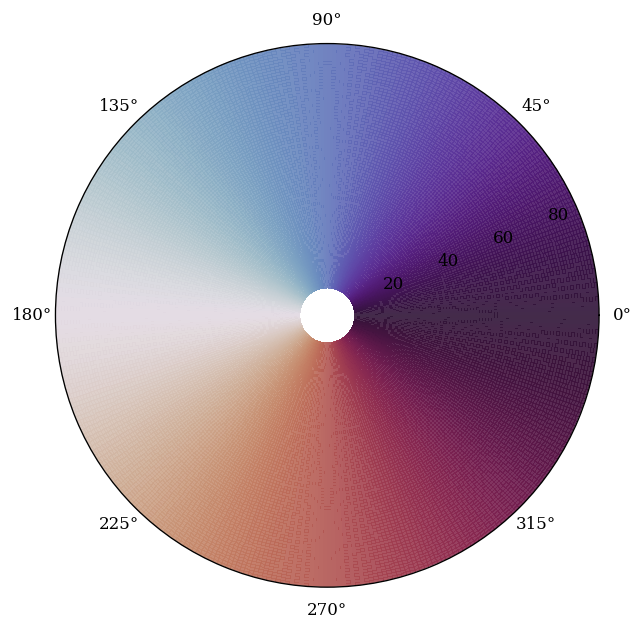

In [67]:
#At the end
low,up = 9400,9500
fir = np.asarray([x for x in firing_data_short if  x[0] > low and x[0] < up])

azimuths = np.arange(0, 361, 1)
zeniths = np.arange(9, 92, 1)
values = azimuths * np.ones((83, 361))
fig, ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'), figsize=(6,6))
ax.pcolormesh(azimuths*np.pi/180.0, zeniths, values[:-1,:-1], cmap=plt.get_cmap('twilight_shifted'),alpha=0.90)
norm_phase = ((fir[:,0])*2*np.pi)
norm_indices = (fir[:,1])+10


theta = np.arange(0,2*np.pi,0.01)
for i in range(10,91,9):
    ax.plot(theta , i*np.ones_like(theta), ls='-', lw=0.2, color='gray')
    
    

ax.plot(norm_phase, norm_indices, color='#FFFF00', marker='.',mew=2, markersize=3, ls='')
ax.set_xticks([])
# ax.set_yticks(range(10,91,10))
# ax.set_axis_on()
plt.savefig(results_dir +str(runnum)+ 'Final Firing Phase Code.png',dpi=120)
# plt.savefig(results_dir +str(runnum)+ 'Initial Firing Phase Code.png')
plt.show()
from matplotlib import cm

# Plot linear raster plot with colour coding at the bottom
raster = plt.figure(figsize=(12,5))
gs = raster.add_gridspec(4,1)
fire = raster.add_subplot(gs[:3])
fire.plot(fir[:,0], fir[:,1], '|k',mew=3,ms=7)
fire.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    fire.axhline(y=i, linewidth=0.2, color='gray')
fire.set_yticks(np.arange(0,81,10))
xlabel('Time (ms)', fontsize=16)
ylabel('Neuron index', fontsize=16)


plt.savefig(results_dir +str(runnum)+ 'Rastor_Colored_Final.png')
plt.show()

In [ ]:
#In the Middle 
low,up = 500,510
k=(low,up)
fir = np.asarray([x for x in firing_data_short if  x[0] > low and x[0] < up])
azimuths = np.arange(0, 361, 1)
zeniths = np.arange(9, 92, 1)
values = azimuths * np.ones((83, 361))
fig, ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'), figsize=(6,6))
ax.pcolormesh(azimuths*np.pi/180.0, zeniths, values[:-1,:-1], cmap=plt.get_cmap('twilight_shifted'),alpha=0.99)
norm_phase = ((fir[:,0])*2*np.pi)
norm_indices = (fir[:,1])+10

theta = np.arange(0,2*np.pi,0.01)
for i in range(10,91,9):
    ax.plot(theta , i*np.ones_like(theta), ls='-', lw=0.2, color='gray')
    
    

ax.plot(norm_phase, norm_indices, color='#FFFF00', marker='.',mew=2, markersize=3, ls='')
ax.set_xticks([])
# plt.savefig(results_dir +str(runnum)+ 'Final Firing Phase Code.png',dpi=120)
plt.savefig(results_dir +str(runnum)+ 'Mid Firing Phase Code.png',dpi=120)
plt.show()

# Plot linear raster plot with colour coding at the bottom
raster = plt.figure(figsize=(12,5))
gs = raster.add_gridspec(4,1)
xlim = k

fire = raster.add_subplot(gs[:3])
fire.plot(fir[:,0], fir[:,1], '|k',mew=3,ms=7)
fire.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    fire.axhline(y=i, linewidth=0.2, color='gray')
fire.set_yticks(np.arange(0,81,10))
xlabel('Time (ms)', fontsize=16)
ylabel('Neuron index', fontsize=16)

plt.savefig(results_dir +str(runnum)+ 'Rastor_Colored_Mid.png',dpi=120)
plt.show()

In [ ]:
#Initial 
low,up = 1500,2000
k=(low,up)
fir = np.asarray([x for x in firing_data_short if  x[0] > low and x[0] < up])
azimuths = np.arange(0, 361, 1)
zeniths = np.arange(9, 92, 1)
values = azimuths * np.ones((83, 361))
fig, ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'), figsize=(6,6))
ax.pcolormesh(azimuths*np.pi/180.0, zeniths, values[:-1,:-1], cmap=plt.get_cmap('twilight_shifted'),alpha=0.99)
norm_phase = ((fir[:,0])*2*np.pi)
norm_indices = (fir[:,1])+10

theta = np.arange(0,2*np.pi,0.01)
for i in range(10,91,9):
    ax.plot(theta , i*np.ones_like(theta), ls='-', lw=0.2, color='gray')
    
    

ax.plot(norm_phase, norm_indices, color='#FFFF00', marker='.',mew=2, markersize=3, ls='')
ax.set_xticks([])
# plt.savefig(results_dir +str(runnum)+ 'Final Firing Phase Code.png',dpi=120)
plt.savefig(results_dir +str(runnum)+ 'Mid Firing Phase Code.png',dpi=120)
plt.show()

# Plot linear raster plot with colour coding at the bottom
raster = plt.figure(figsize=(12,5))
gs = raster.add_gridspec(4,1)
xlim = k

fire = raster.add_subplot(gs[:3])
fire.plot(fir[:,0], fir[:,1], '|k',mew=3,ms=7)
fire.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    fire.axhline(y=i, linewidth=0.2, color='gray')

fire.set_yticks(np.arange(0,81,10))
xlabel('Time (ms)', fontsize=16)
ylabel('Neuron index', fontsize=16)


plt.savefig(results_dir +str(runnum)+ 'Rastor_Colored_Mid.png',dpi=120)
plt.show()

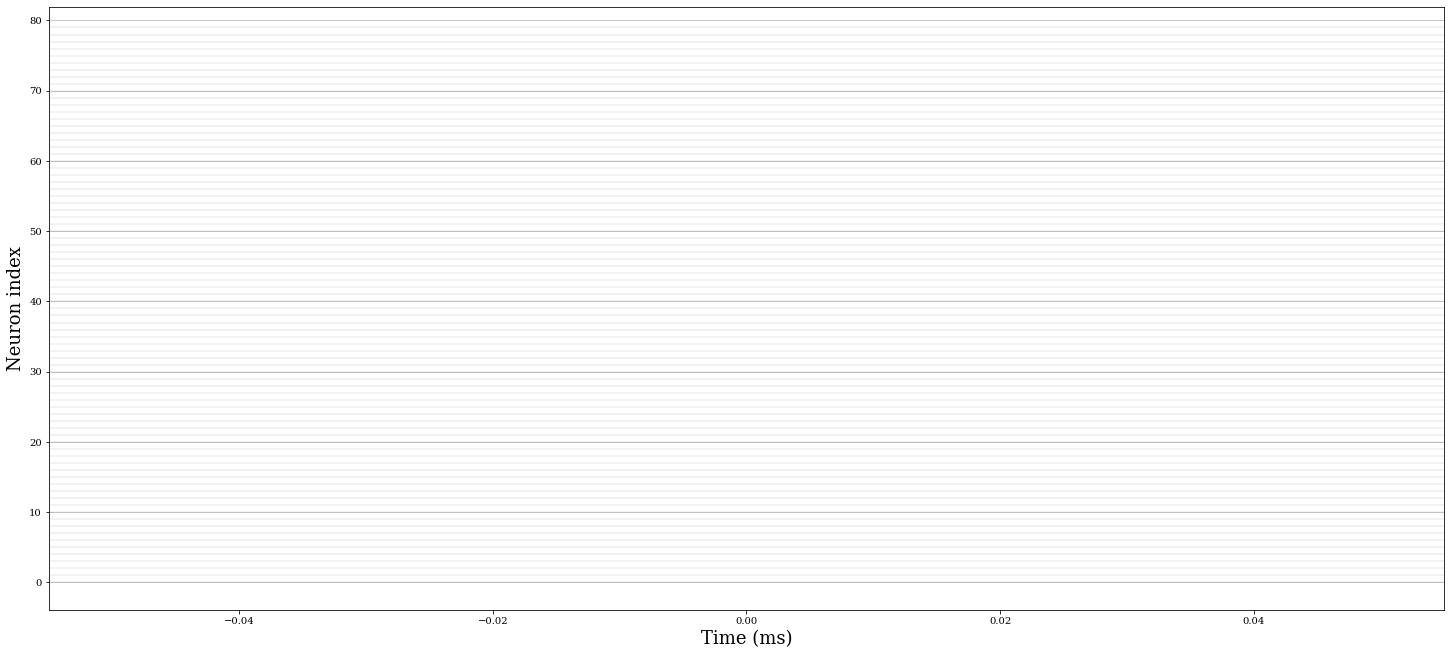

In [68]:
fig = figure(figsize=(25,15))
#x_lim = (3950,3990)

gs = fig.add_gridspec(4,1)
ax=fig.add_subplot(gs[1:,:])
ax.plot(firing_time.t/ms, firing_time.i,'|k', markerfacecolor='xkcd:salmon', mew=1,markersize=7)
#ax.set_xlim(x_lim)
ax.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    ax.axhline(y=i, linewidth=0.2, color='gray')
csfont = {'fontname':'sans-serif'}
hfont = {'fontname':'serif'}
plt.rc('xtick', labelsize=10)
xlabel('Time (ms)',**hfont,fontsize=18)
ylabel('Neuron index',**hfont,fontsize=18)
# title('DC input at '+str(I) +', Intermittent Input Weight '+str(max(ts))+ ', and'+str(min_block)+' ms with Offset Probability= 0.4', fontsize=18,**hfont,fontweight="bold")

plt.savefig(results_dir +str(runnum)+ 'Full Raster plot.png',dpi=120)
show()

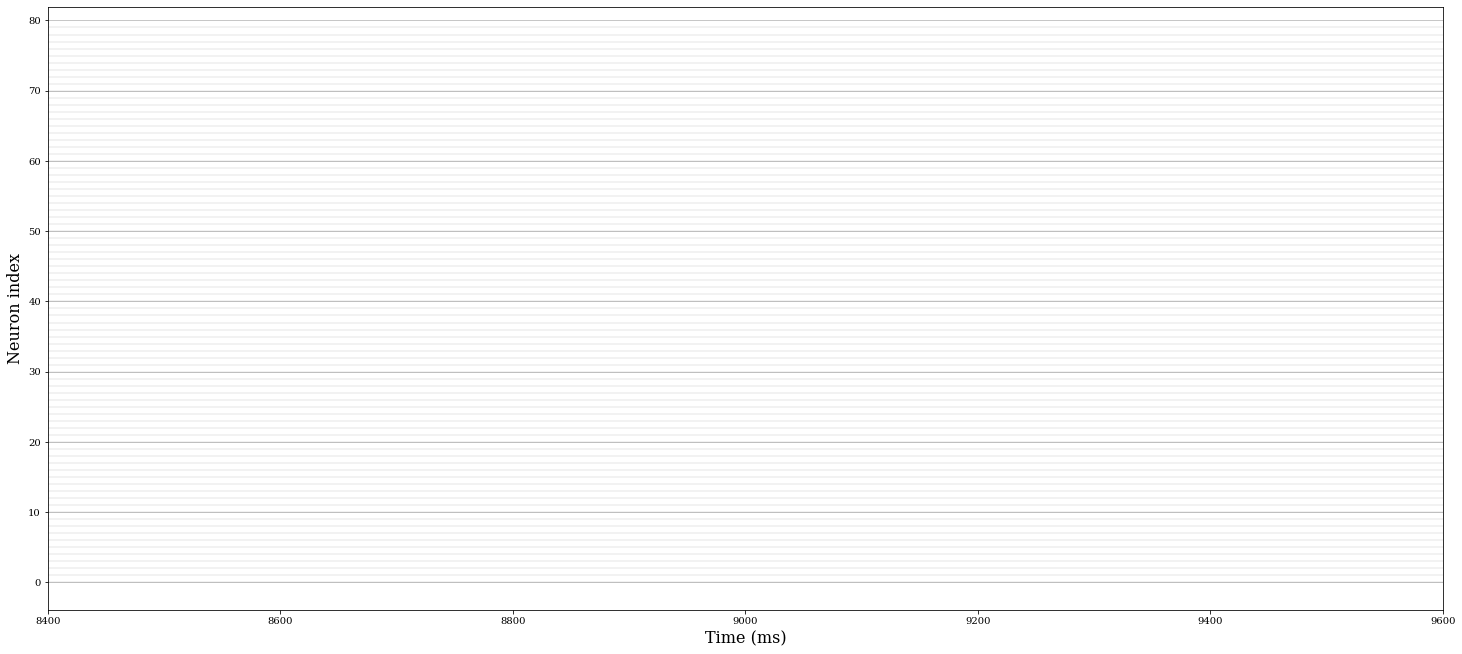

In [69]:
#Final State of Firing of Neurons at the end of the simulation

fig = figure(figsize=(25,15))

gs = fig.add_gridspec(4,1)
ax=fig.add_subplot(gs[1:,:])
ax.plot(firing_time.t/ms, firing_time.i,'|k', markerfacecolor='xkcd:salmon', mew=3,markersize=6)
#ax.set_xlim(x_lim)
ax.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    ax.axhline(y=i, linewidth=0.2, color='gray')
csfont = {'fontname':'sans-serif'}
hfont = {'fontname':'serif'}
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)
x_lim = (8400,9600)
ax.set_xlim(x_lim)
xlabel('Time (ms)',**hfont,fontsize=16)
ylabel('Neuron index',**hfont,fontsize=16)
# title('DC input of '+str(I) +', Intermittent Input Weight '+str(max(ts))+ ', and'+str(min_block)+' ms with Offset Probability = 0.4', fontsize=18,**hfont,fontweight="bold")

plt.savefig(results_dir +str(runnum)+ 'End_Raster_plot.png',dpi=120)
show()